## Project End Goal
> Be able to predict the prices of various used cars

## Importing Important Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor as xgbr
import pickle

import warnings
warnings.filterwarnings('ignore')

c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv('true_car_listings.csv')
data.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


## Exploratory Data Anslysis

In [3]:
# dropping the VIN(Vehicle Identification Number) as vehicle unique ID 
# is not a factor to consider for price prediction as each vegicle has its unique VIN
data = data.drop('Vin', axis= 1)
data.head()

,Price,Year,Mileage,City,State,Make,Model
0,8995,2014,35725,El Paso,TX,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,Acura,ILXAutomatic


In [4]:
data.isnull().sum()

Price      0
Year       0
Mileage    0
City       0
State      0
Make       0
Model      0
dtype: int64

In [5]:
data.describe().round()

,Price,Year,Mileage
count,852122.0,852122.0,852122.0
mean,21464.0,2013.0,52508.0
std,13596.0,3.0,41989.0
min,1500.0,1997.0,5.0
25%,13000.0,2012.0,23836.0
50%,18500.0,2014.0,40256.0
75%,26995.0,2016.0,72186.0
max,499500.0,2018.0,2856196.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852122 non-null  int64 
 1   Year     852122 non-null  int64 
 2   Mileage  852122 non-null  int64 
 3   City     852122 non-null  object
 4   State    852122 non-null  object
 5   Make     852122 non-null  object
 6   Model    852122 non-null  object
dtypes: int64(3), object(4)
memory usage: 45.5+ MB


In [7]:
data.corr('spearman')

,Price,Year,Mileage
Price,1.000000,0.519913,-0.546931
Year,0.519913,1.000000,-0.780905
Mileage,-0.546931,-0.780905,1.000000


* from the correlation results above, year purchased and Mileage seem to have a good enough correlation with the price of the vehicle, I will go ahead to plot the effect of various attributes on price

## Data Visualization

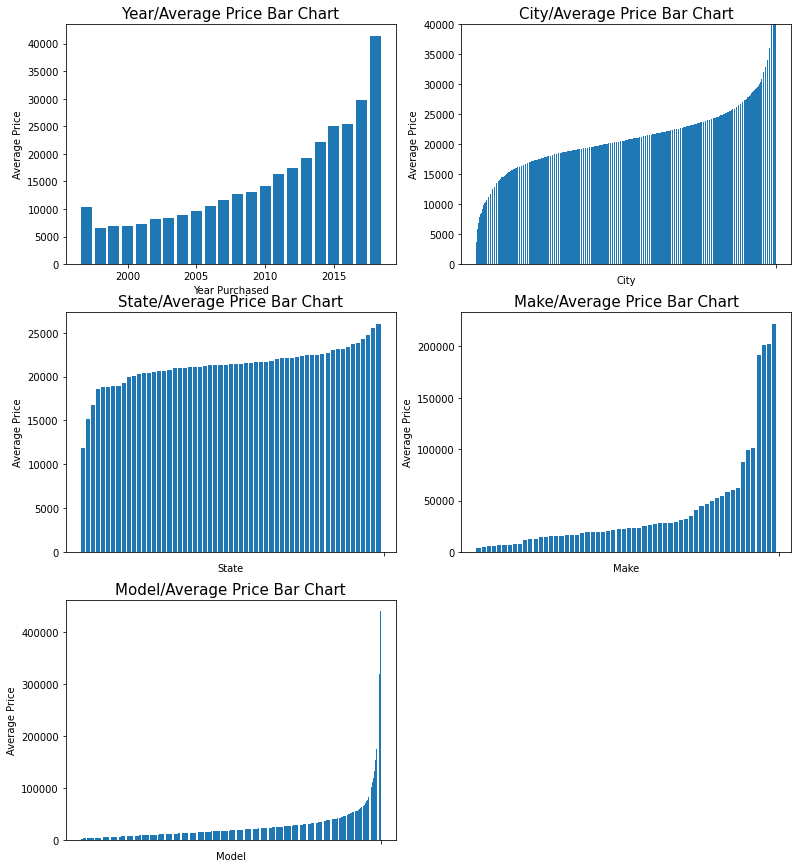

In [11]:
# Visualization 
# Calculating mean prices of cars grouped by year

plt.figure(figsize =(13,15))
year_price = data.groupby('Year')['Price'].mean().sort_values(ascending=True)
plt.subplot(3,2,1)
plt.bar(year_price.index, year_price.values)
plt.title("Year/Average Price Bar Chart", fontsize=15)
plt.xlabel("Year Purchased")
plt.ylabel("Average Price")

# Calculating mean prices of cars grouped by the City
city_price = data.groupby('City')['Price'].mean().sort_values(ascending=True)
plt.subplot(3,2,2)
plt.bar(city_price.index, city_price.values)
plt.title("City/Average Price Bar Chart", fontsize=15)
plt.xlabel("City")
plt.ylabel("Average Price")
plt.xticks([''])
plt.ylim([0,40000])

# Calculating mean prices of cars grouped by the State
state_price = data.groupby('State')['Price'].mean().sort_values(ascending=True)
plt.subplot(3,2,3)
plt.bar(state_price.index, state_price.values)
plt.title("State/Average Price Bar Chart", fontsize=15)
plt.xlabel("State")
plt.ylabel("Average Price")
plt.xticks([''])

# Calculating mean prices of cars grouped by the Make
make_price = data.groupby('Make')['Price'].mean().sort_values(ascending=True)
plt.subplot(3,2,4)
plt.bar(make_price.index, make_price.values)
plt.title("Make/Average Price Bar Chart", fontsize=15)
plt.xlabel("Make")
plt.ylabel("Average Price")
plt.xticks([''])

# Calculating mean prices of cars grouped by the State
model_price = data.groupby('Model')['Price'].mean().sort_values(ascending=True)
plt.subplot(3,2,5)
plt.bar(model_price.index, model_price.values)
plt.title("Model/Average Price Bar Chart", fontsize=15)
plt.xlabel("Model")
plt.ylabel("Average Price")
plt.xticks([''])

plt.show()

In [8]:
data_freq_enc = data.copy(deep=True)

#### Converting all nominal data types into integer with the frequency enocding method 

In [9]:
# Calculatig frequency of all nominal categorial features.

city_freq = data_freq_enc.groupby('City').size()/len(data.City)
state_freq = data_freq_enc.groupby('State').size()/len(data.State)
make_freq = data_freq_enc.groupby('Make').size()/len(data.Make)
model_freq = data_freq_enc.groupby('Model').size()/len(data.Model)

# mapping columns to dataframe
data_freq_enc['City'] = data_freq_enc['City'].map(city_freq)
data_freq_enc['State'] = data_freq_enc['State'].map(state_freq)
data_freq_enc['Make'] = data_freq_enc['Make'].map(make_freq)
data_freq_enc['Model'] = data_freq_enc['Model'].map(model_freq)

In [11]:
for key, value in make_freq.items():
    print(key)


AM
Acura
Alfa
Aston
Audi
BMW
Bentley
Buick
Cadillac
Chevrolet
Chrysler
Dodge
FIAT
Ferrari
Fisker
Ford
Freightliner
GMC
Genesis
Geo
HUMMER
Honda
Hyundai
INFINITI
Isuzu
Jaguar
Jeep
Kia
Lamborghini
Land
Lexus
Lincoln
Lotus
MINI
Maserati
Maybach
Mazda
McLaren
Mercedes-Benz
Mercury
Mitsubishi
Nissan
Oldsmobile
Plymouth
Pontiac
Porsche
Ram
Rolls-Royce
Saab
Saturn
Scion
Subaru
Suzuki
Tesla
Toyota
Volkswagen
Volvo
smart


58

In [22]:
len(data_freq_enc.Make.unique())

57

In [29]:
data_freq_enc.head()

,Price,Year,Mileage,City,State,Make,Model
0,8995,2014,35725,0.003589,0.111080,0.012966,0.000022
1,10888,2013,19606,0.001915,0.032779,0.012966,0.000775
2,8995,2013,48851,0.003589,0.111080,0.012966,0.000022
3,10999,2014,39922,0.000499,0.026996,0.012966,0.000775
4,14799,2016,22142,0.000561,0.012226,0.012966,0.000219


In [30]:
data_freq_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Price    852122 non-null  int64  
 1   Year     852122 non-null  int64  
 2   Mileage  852122 non-null  int64  
 3   City     852122 non-null  float64
 4   State    852122 non-null  float64
 5   Make     852122 non-null  float64
 6   Model    852122 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 45.5 MB


In [25]:
# splitting data into test and train set

x= data_freq_enc.drop('Price', axis=1)
y= data_freq_enc['Price']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=30)

In [26]:
print('length of training set', len(x_train))
print('length of testing set', len(x_test))

length of training set 681697
length of testing set 170425


## Models Training

### XGBoost Regressor

In [35]:
# Model training without hyper parameters
xgbr_model = xgbr()
xgbr_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
# performance evaluation

test = xgbr_model.predict(x_test)
train = xgbr_model.predict(x_train)
score1 = r2_score(y_test, test)
score2 = r2_score(y_train, train)
print(f'Accuracy on test set: {round(score1*100,2)}%')
print(f'Accuracy on train set: {round(score2*100,2)}%')

Accuracy on test set: 85.64%
Accuracy on train set: 87.21%


### Best fit hyper parameters search

In [37]:
# defining list of parameters for randomized search.

params = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [7, 8],
    'n_estimators': [100, 200, 300],
}

# cv=5 means data will be split into 5. 4 set as training data while the last 1 is set as testing data. 
rand_search = RandomizedSearchCV(xgbr_model, param_distributions=params, cv=5, n_jobs=-1, verbose=0)
rand_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=8,
                                          num_parallel_tree=1, predictor='auto',
                                          random_stat

In [38]:
print(f'Grid search hyper-parameters accuracy on train set - {round(rand_search.score(x_train, y_train)*100,2)}%')
print(f'Grid search hyper-parameters accuracy on test set - {round(rand_search.score(x_test, y_test)*100,2)}%')

Grid search hyper-parameters accuracy on train set - 93.63%
Grid search hyper-parameters accuracy on test set - 89.98%


> The results above are good enough, the distance between the train and test results are increasing. To avoid over fitting on training data, model will trained with the current best estimators.

In [39]:
rand_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [27]:
# training model with best estimators and calculating squared error to check model performance
evalset = [(x_train, y_train), (x_test,y_test)]
xgbr_model = xgbr(learning_rate=0.3, max_depth=8, n_estimators=300)
xgbr_model.fit(x_train, y_train, eval_metric='rmse', eval_set=evalset)

[0]	validation_0-rmse:18937.45508	validation_1-rmse:18910.88281
[1]	validation_0-rmse:14620.35059	validation_1-rmse:14632.74902
[2]	validation_0-rmse:11769.35449	validation_1-rmse:11826.57715
[3]	validation_0-rmse:9944.29004	validation_1-rmse:10013.77539
[4]	validation_0-rmse:8886.88965	validation_1-rmse:8971.32812
[5]	validation_0-rmse:8216.90527	validation_1-rmse:8322.77246
[6]	validation_0-rmse:7811.82031	validation_1-rmse:7932.36230
[7]	validation_0-rmse:7455.09570	validation_1-rmse:7588.41016
[8]	validation_0-rmse:7222.16309	validation_1-rmse:7360.68603
[9]	validation_0-rmse:6973.92188	validation_1-rmse:7122.33936
[10]	validation_0-rmse:6841.50391	validation_1-rmse:7003.53125
[11]	validation_0-rmse:6732.74902	validation_1-rmse:6900.96533
[12]	validation_0-rmse:6558.89893	validation_1-rmse:6735.70361
[13]	validation_0-rmse:6465.84619	validation_1-rmse:6647.13525
[14]	validation_0-rmse:6220.95801	validation_1-rmse:6405.52490
[15]	validation_0-rmse:6071.39795	validation_1-rmse:6253.9

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [28]:
# adjusted model performance evaluation
test_new = xgbr_model.predict(x_test)
train_new = xgbr_model.predict(x_train)
score1 = r2_score(y_test, test_new)
score2 = r2_score(y_train, train_new)
print(f'Accuracy on test set: {round(score1*100,2)}%')
print(f'Accuracy on train set: {round(score2*100,2)}%')

Accuracy on test set: 90.24%
Accuracy on train set: 94.41%


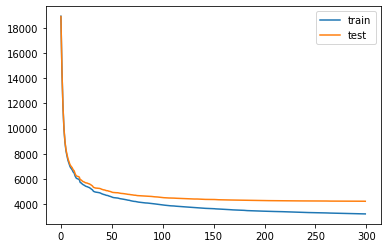

In [42]:
# Plotting visualzation of root mean square error against number of estimators from 0 to 300
# to visually represent as test and train set predictions results rmse grow appart with increasing number of estimators

results = xgbr_model.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [29]:
# save the model to disk
filename = 'finalized_model'
pickle.dump(xgbr_model, open(filename, 'wb'))